In [1]:
%load_ext autoreload
%autoreload 2

# Comparing Neural Network Regression Methods with Uncertainty Estimation: A Case Study on Concrete Strength Prediction


**This project presents a performance comparison of regression methods that provide the uncertainty estimates along the forcasted regression value. The Concrete Strength dataset is used to perform this case study.**


In regression problems the models are predicting continuous values often but not necessarily bounded between -1 to 1 or 0 to 1. On the other hand, for classification problems each class usually has a predicted score. After passing the scores through softmax, the probabilities can be interpreted as uncertainty estimates, with the higher probability of a class indicating lower uncertainty in the prediction. In the regression problems however, estimating the uncertainty is not as straightforward.

In a difficult regression problem trained with a Mean Squared Error (MSE) loss, the model tends to converge towards the mean target for the instances that it cannot fit accurately. For example if there are multiple instances in the train dataset that have nearly identical input features but very different target values, the regression model will converge towards their mean target values to minimize the MSE loss.

As a result, for predictions that lie closer to the overall mean target values of the train dataset, it is almost impossible to say whether the model is confident about the forecasted values or if it is just approximation values to minimize the MSE loss. In contrast, the predictions which further away from the overall mean target values of the train dataset can sometimes be considered as higher confidence prediction since predicting far from the mean can cause higher MSE penalty if the model is wrong.

For example, consider a regression problem where the target values are bounded between -1 and 1 and the model’s mean prediction on the training set is close to zero. If the model is predicting 0.1 as the target value of a instance, it is unclear whether the model is confident about this prediction value or if it is just an estimation towards the mean target values to minimize the MSE loss. However, if a prediction value is 0.8, it might mean that the model is more confident about the predicted target value (although this interpretation is not always accurate).

This assumption mainly relates to aleatoric uncertainty in which the uncertainty is intrinsic, random, and noise in data itself. Aforementioned assumption is not valid for the epistemic uncertainty which is educible uncertainty due to a lack of knowledge or data.

* **Aleatoric uncertainty** represents the intrinsic randomness or noise in the data itself. Aleatoric uncertainty cannot be reduced by collecting more data, because it comes from the natural randomness in the data, such as measurement errors or naturally stochastic processes.

* **Epistemic uncertainty** arises from a lack of knowledge, data, or model capacity. It happens where the model doesn't know due to a small train dataset, or unseen regions of the input space. Unlike aleatoric uncertainty, epistemic uncertainty can be reduced by improving the model structure or gathering more diverse data.


Accordingly, in the aforementioned example, the model could still be uncertain for a 0.8 prediction value due to not enough data or unseen regions of the input space (aleatoric uncertainty).





## Regression methods with uncertainty estimation to test

* **Mean + STD**
    * Model predicts the mean as the predicted target value and predicts std value as uncertainty measure where the higher predicted std means higher uncertainty.

* **Mean + Variance (NLL)**
    * Model predicts the mean as the predicted target value and predicts variance value as uncertainty measure where the higher predicted variance means higher uncertainty.

* **Monte Carlo Dropout**
    * The model trains with dropout layers, and unlike in conventional approach, the dropout layers are kept enabled in prediction phase. The model predicts the same instance multiple times. Since the dropout layers are enabled, prediction values slightly differ from each other. Then the mean of the predictions is considered as the predicted target value, and the standard deviation of the predictions is considered as uncertainty estimate.

* **Simplified PPO method for supervised learning**
    * PPO is an unsupervised reinforcement learning method and is not directly meant for supervised regression problem. However, due to having standard deviation prediction for exploration purpose, a modified and simplified version of PPO is selected as one of the candidate approaches in this study. Here the actor model is going to predict the mean as the target value and the standard deviation as the uncertainty estimate.

| Method                | Aleatoric Uncertainty | Epistemic Uncertainty | Easy to Implement | Notes                         |
| --------------------- | :---------: | :---------: | :-----------------: | ----------------------------- |
| Mean + STD            | ✅        | ❌        | ✅✅              | Great for noisy data          |
| Mean + Variance (NLL) | ✅        | ❌        | ✅✅              | Great for noisy data          |
| MC Dropout            | ❌        | ✅        | ✅✅              | Adds stochasticity            |
| Simplified PPO method | ✅        | ❌        | ✅                | Not primarily meant for regression      |




## Implementation

### Import dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from src.dataset import load_concrete_dataset
from src.model import BaselineModel, MeanSTDModel, MeanVarianceModel, MonteCarloDropoutModel, PPOModel
from src.trainer import BaselineModelTrainer, MeanSTDModelTrainer, MeanVarianceModelTrainer, MonteCarloDropoutModelTrainer, PPOModelTrainer
from src.evaluate import evaluate_models_mse, evaluate_models_true_vs_pred, plot_mse_vs_uncertainty_quantile

### Loading the Concrete Compressive Strength dataset

Randomely selecting 60% of data for train and the rest 40% for test.

In [3]:
train_dataset, test_dataset = load_concrete_dataset(train_ratio=0.7)

### Defining models

The base model for all the methods is a simple model with Linear layers. It has 4 hidden layers of size 64.
The output layers of each method is defined in its own corresponding model.

For more implementation and sructural details please check the `model.py` file at path `./src/model.py`

In [4]:
input_size = train_dataset.features.size(1)
hidden_sizes = [64, 64, 64, 64, 64]
output_size = 1

baseline_model = BaselineModel(
    input_size=input_size, 
    output_size=output_size,
    hidden_sizes=hidden_sizes,
    dropout_prob=0.0
)

mean_std_model = MeanSTDModel(
    input_size=input_size,
    output_size=output_size,
    hidden_sizes=hidden_sizes,
    dropout_prob=0.0
)

mean_variance_model = MeanVarianceModel(
    input_size=input_size, 
    output_size=output_size,
    hidden_sizes=hidden_sizes, 
    dropout_prob=0.0
)

monte_carlo_dropout_model = MonteCarloDropoutModel(
    input_size=input_size, 
    output_size=output_size,
    hidden_sizes=hidden_sizes
)

ppo_model = PPOModel(
    input_size=input_size, 
    output_size=output_size, 
    hidden_sizes=hidden_sizes, 
    dropout_prob=0.0
)



### Training models

Training all the models for 2000 epochs with the batch size of 256 and a learning rate of 0.0001.

In [5]:
baseline_trainer = BaselineModelTrainer(
    baseline_model, 
    train_dataset, 
    num_epochs=2000, 
    batch_size=256, 
    learning_rate=0.0001, 
    device='cuda'
)
baseline_trainer.train()

Training Progress: 100%|██████████| 2000/2000 [00:08<00:00, 249.09it/s, loss=0.000318]


In [6]:
mean_std_model_trainer = MeanSTDModelTrainer(
    mean_std_model, 
    train_dataset, 
    num_epochs=2000, 
    batch_size=256, 
    learning_rate=0.0001, 
    device='cuda'
)
mean_std_model_trainer.train()


Training Progress: 100%|██████████| 2000/2000 [00:10<00:00, 196.08it/s, loss=-2.71]


In [7]:
mean_variance_model_trainer = MeanVarianceModelTrainer(
    mean_variance_model, 
    train_dataset, 
    num_epochs=2000, 
    batch_size=256, 
    learning_rate=0.0001,
    device='cuda'
)
mean_variance_model_trainer.train()


Training Progress: 100%|██████████| 2000/2000 [00:08<00:00, 234.16it/s, loss=-3.23]


In [8]:
monte_carlo_dropout_model_trainer = MonteCarloDropoutModelTrainer(
    monte_carlo_dropout_model, 
    train_dataset, 
    num_epochs=2000, 
    batch_size=256, 
    learning_rate=0.0001, 
    device='cuda'
)
monte_carlo_dropout_model_trainer.train()


Training Progress: 100%|██████████| 2000/2000 [00:29<00:00, 68.24it/s, loss=0.000902]


In [9]:
ppo_model_trainer = PPOModelTrainer(
    ppo_model, 
    train_dataset, 
    num_epochs=2000, 
    batch_size=256, 
    learning_rate=0.0001, 
    sample_size=100,
    learn_steps=1, 
    device='cuda'
)
ppo_model_trainer.train()

Training Progress: 100%|██████████| 2000/2000 [00:16<00:00, 122.36it/s, reward=-0.00306]


### Evaluation

The first evaluation is to simply plot the MSE of each method on the train and test sets. Here you can find the train MSE of the models on the left plot and the test on the right plot.

Baseline: Train MSE=0.000311, Test MSE=0.002421
Mean STD: Train MSE=0.000650, Test MSE=0.002999
Mean Variance: Train MSE=0.001068, Test MSE=0.003644
Monte Carlo Dropout: Train MSE=0.000661, Test MSE=0.002999
PPO: Train MSE=0.000326, Test MSE=0.003284


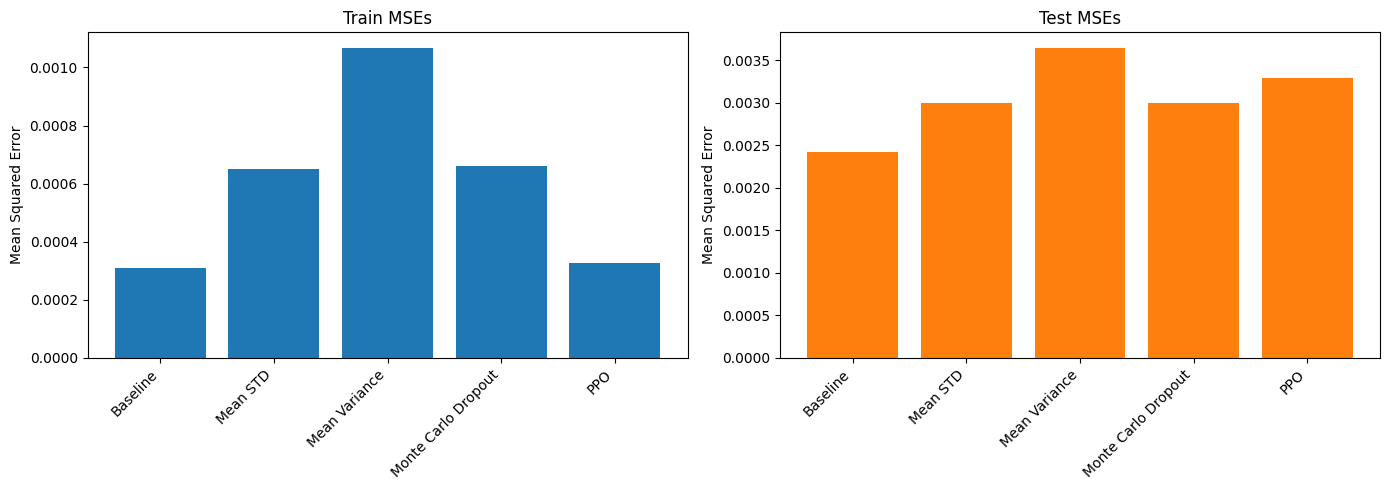

In [10]:
evaluate_models_mse(
    models=[
        baseline_model,
        mean_std_model,
        mean_variance_model,
        monte_carlo_dropout_model,
        ppo_model,
    ],
    titles=[
        "Baseline",
        "Mean STD",
        "Mean Variance",
        "Monte Carlo Dropout",
        "PPO",
    ],
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    device='cuda'
)

According to the plot, the baseline method has the least test set MSE and the Mean Variance has the highest MSE. The Mean STD and the MC Dropout models are equally performing the same on test set at the second place and the PPO model is the third best performer on the test set.

<br>
<br>
<br>

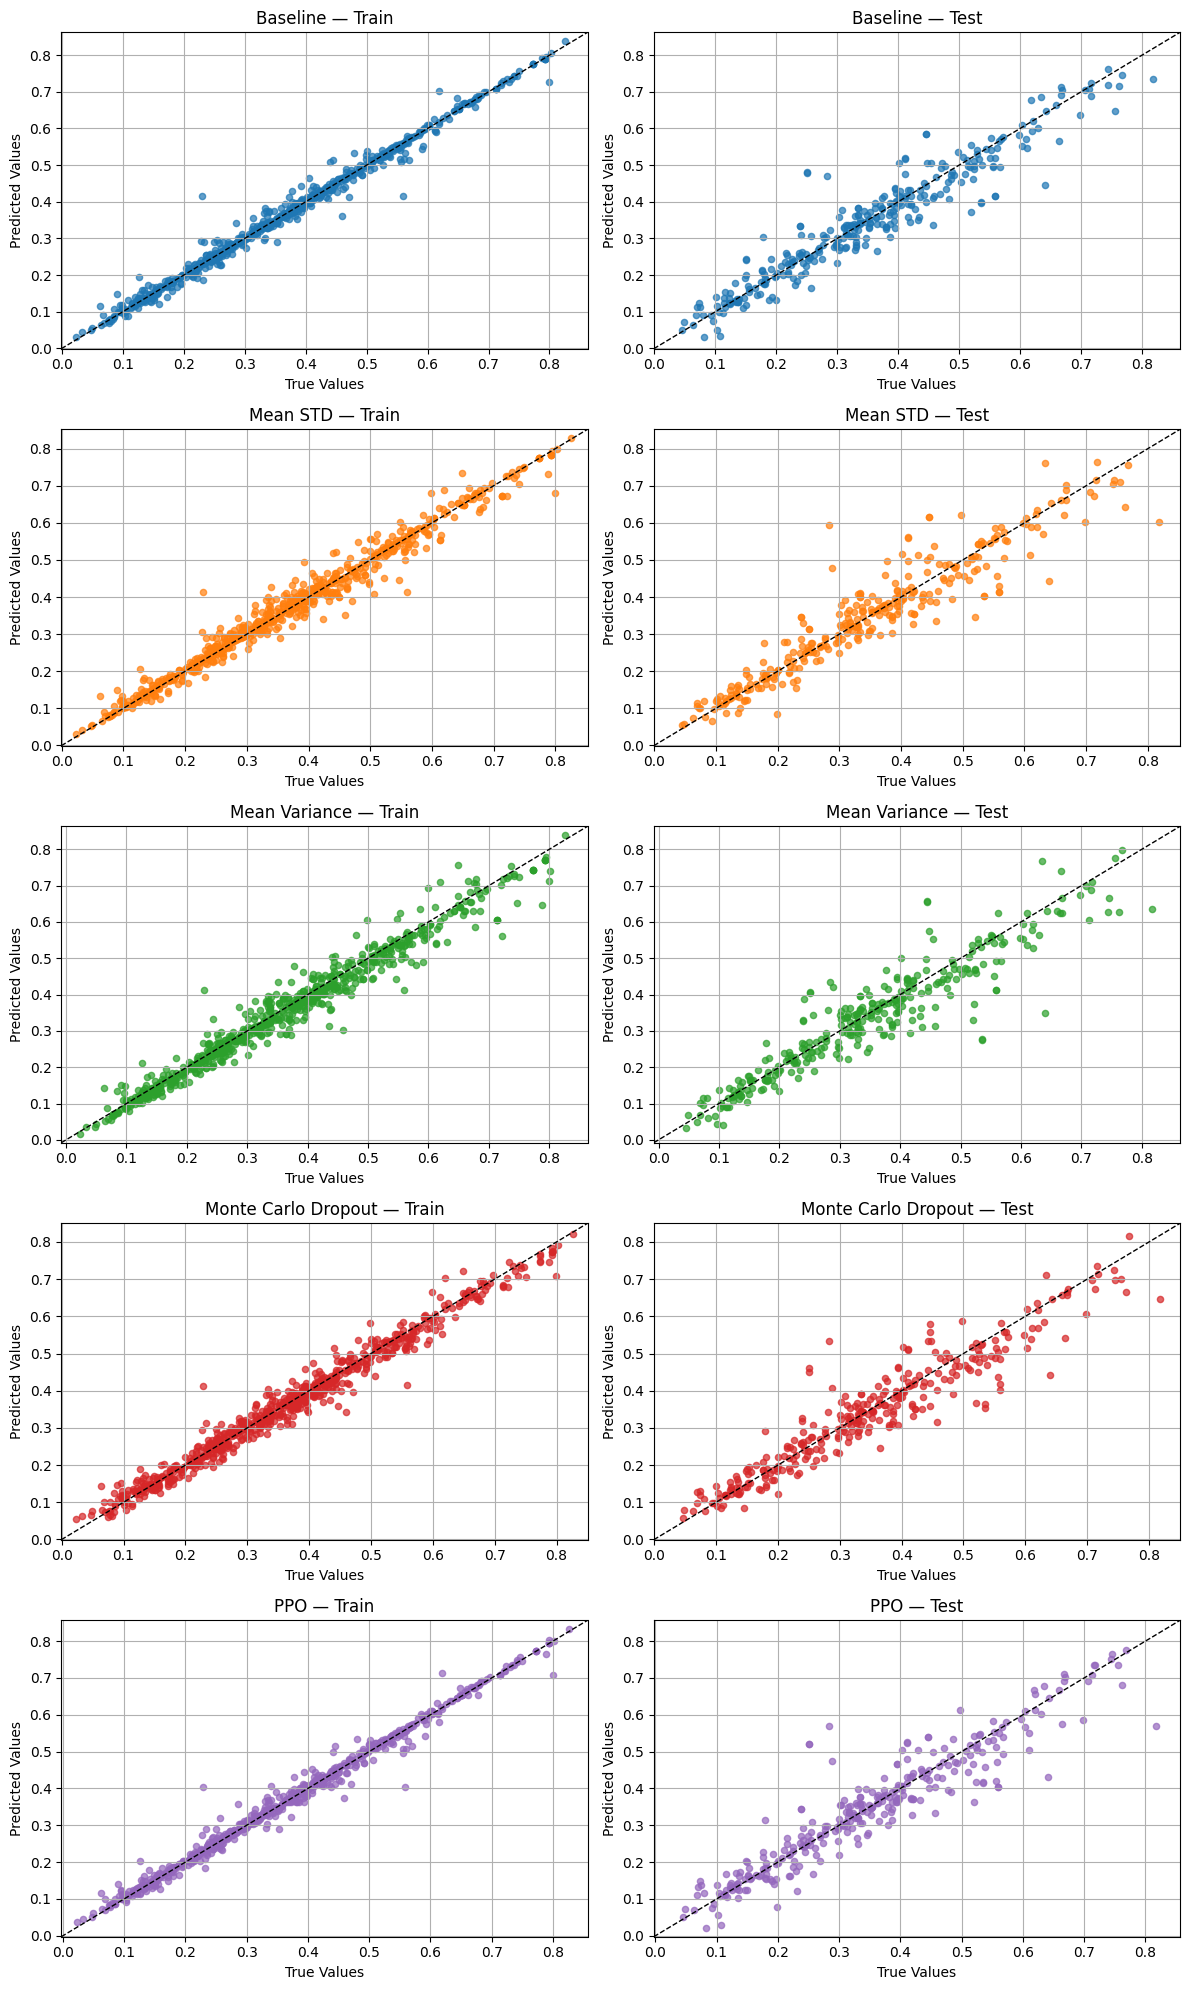

In [11]:
evaluate_models_true_vs_pred(
    models=[
        baseline_model,
        mean_std_model,
        mean_variance_model,
        monte_carlo_dropout_model,
        ppo_model,
    ],
    titles=[
        "Baseline",
        "Mean STD",
        "Mean Variance",
        "Monte Carlo Dropout",
        "PPO",
    ],
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    device='cuda'
)

This plot visualizes the train and test set predictions of the models in plots with X-axis being the actual target value and Y-axis being the predicted target value. Accordingly, the closer the points are to the diagonal line, the more accurate predictions are.

<br>
<br>
<br>

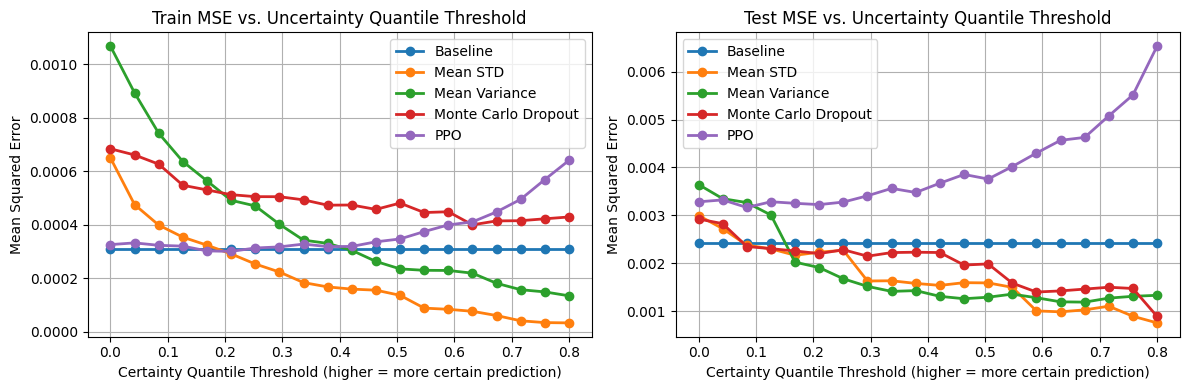

In [12]:
plot_mse_vs_uncertainty_quantile(
    models=[
        baseline_model,
        mean_std_model,
        mean_variance_model,
        monte_carlo_dropout_model,
        ppo_model,
    ],
    titles=[
        "Baseline",
        "Mean STD",
        "Mean Variance",
        "Monte Carlo Dropout",
        "PPO",
    ],
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    device='cuda'
)

This plot depicts how good the uncertainty estimation is working for each method. X-axis is showing the confidence measure threshold to select the predictions with higher certainty. In other words, x-axis shows the ignored percentage of the least certain predictions. For example 0.3 certainty in the x-axis means 30% of the least certain predictions are ignored and the 70% of the most certain predictions are selected. Y-axis is showing the MSE of the selected instances corresponding to the confidence measure on x-axis.

The baseline method is a simple regression method and it does not provide any uncertainty estimation, so it has a constant MSE over the confidence axis. With a simple glance, it is visible that the PPO method is not performing very well. Even though, the PPO method has a similar overall MSE of all the test set to other approaches, its uncertainty estimation is not working as expected. Intuitively, the lower standard deviation should mean more confidence in prediction. However, it seems to be working the other way around and by selecting the predictions with lower std, the MSE is increasing. This could be related to the fact that predicting std in PPO is a way to ensure the exploration to get higher rewards, where the instances that lower predicted std than others might have gotten less chance of exploration compared to the other instances.

According to the plot, Mean STD, Mean Variance and MC Dropout methods are offering fairly similar performance as certainty threshold goes higher. Mean STD method seems to perform the best at providing uncertainty estimate as it still decreasing the MSE after 0.55 certainty threshold unlike the Mean Variance method.







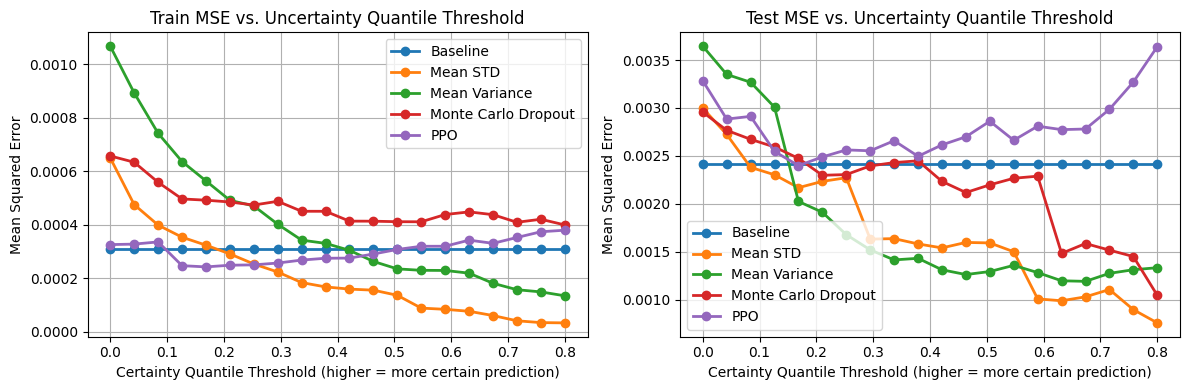

In [14]:
plot_mse_vs_uncertainty_quantile(
    models=[
        baseline_model,
        mean_std_model,
        mean_variance_model,
        monte_carlo_dropout_model,
        ppo_model,
    ],
    titles=[
        "Baseline",
        "Mean STD",
        "Mean Variance",
        "Monte Carlo Dropout",
        "PPO",
    ],
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    device='cuda'
)

Since the PPO method's uncertainty estimate seems to be working in reverse, this plot shows PPO method's MSE based on its reversed order of uncertainty estimate. In other words, the most certain prediction by PPO is considered as the least certain and the least certain prediction is considered as the most certain. Even though the MSE seems to be reducing from 0 to 0.2 certainty threshold, it goes back higher after 0.2 certainty threshold. So even the reversed order of uncertainty estimations of the PPO method seems to be not providing the correct uncertainty estimation either.

### Verdict

According to the tests of the uncertainty estimation methods with the Concrete Strength dataset, the Mean STD and the Mean Variance methods provided the best performance at estimating the prediction uncertainty.